# PLAXIS Python Plugin

## Import libraries
Connect to the scripting reference: http://localhost:8888/notebooks/contents_2d.ipynb

In [56]:
from plxscripting.easy import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.path import Path
from scipy.interpolate import griddata
from geometry import plot_geometry

colors = ['#0000ff', '#0033ff', '#0066ff', '#0099ff', '#00ccff',
    '#00ffff', '#33ffcc', '#66ff99', '#99ff66', '#ccff33',
    '#ffff00', '#ffcc00', '#ff9900', '#ff6600', '#ff3300',
    '#ff0000']

# Create the colormap
cmap_PLAXIS = ListedColormap(colors)

## Connect to Plaxis server

In [57]:
# Initialize Input server
localhost_input = 10000
password_input = 'YQ+R8$e5xy+G26z~'
s_i, g_i = new_server('localhost', localhost_input, password=password_input)


# Initialize output server
localhost_output = 10001
password_output = 'YQ+R8$e5xy+G26z~'
s_o, g_o = new_server('localhost', localhost_output, password=password_output)

In [58]:
s_i.open(r'C:\Users\nielsvanvliet\PLAXIS_models\test.p2dx')

'OK'

## Soil
Download the soil layers of the HSss model from the TAK

In [59]:
df = pd.read_csv("../soillayers.csv", skiprows=[0], encoding='latin1')
df.head()

,Layer,Dutchname,gammadry,gammasat,cref,phi,psi,E50ref,Eoedref,Eurref,gamma07,G0ref,m
0,0,Verharding,18.0,20.0,0.5,32.5,2.5,20000,20000,60000,0.0001,89500,0.5
1,1,Ophooglaag,17.0,19.0,1.0,30.0,0.0,17134,15000,50000,0.0001,81000,0.5
2,7,GeulopvullingKlei,13.9,13.9,7.1,20.0,0.0,4284,2200,15000,0.0002,15000,0.8
3,8,Hollandveen,10.5,10.5,3.6,18.0,0.0,2000,1085,7000,0.0002,7000,0.8
4,9,OudeZeeklei,16.5,16.5,5.0,26.0,0.0,7500,3780,20000,0.0002,47000,0.8


Import the materials to PLAXIS

In [60]:
# Iterate over the rows of the dataframe and create materials
for _, row in df.iterrows():
    # Extract the necessary parameters from the row
    params = [
        ("SoilModel", "HS small"),
        ("Identification", row['Dutchname']),
        ("E50ref", row['E50ref']),
        ("phi", row['phi']),
        ("cref", row['cref']),
        ("psi", row['psi']),
        ("gammaunsat", row['gammadry']),
        ("gammasat", row['gammasat']),
        ("Eoedref", row['Eoedref']),
        ("Eurref", row['Eurref']),
        ("gamma07", row['gamma07']),
        ("G0ref", row['G0ref']),
        ("powerm", row['m'])
    ]
    
    # Create the soil material using the g_i.soilmat function
    material = g_i.soilmat(*params)

In [61]:
# Set Allerod material with different properties, otherwise the program throws error
g_i.Allerod.EOedRef = 7567

### Initialize soil contour

Bottoms layers for quick initialization and thereafter add the other layers as separate polygons.

In [62]:
# Initialize soil contour
xmin = -15
xmax = 15
ymin = -20
ymax = 0.580
g_i.SoilContour.initializerectangular(xmin, ymin, xmax, ymax)

# Set borehole
g_i.borehole(0)
g_i.Borehole_1.Head = -0.4 # [m]

# Define the number of soil layers
n_soillayers = 7
for n in range(n_soillayers):
    g_i.soillayer(1)

# Adjust thickness of the soil layers
g_i.Soillayer_1.Zones[0].Top = -3.7
g_i.Soillayer_1.Zones[0].Bottom = -5
g_i.Soillayer_2.Zones[0].Bottom = -12
g_i.Soillayer_3.Zones[0].Bottom = -12.5
g_i.Soillayer_4.Zones[0].Bottom = -13
g_i.Soillayer_5.Zones[0].Bottom = -15
g_i.Soillayer_6.Zones[0].Bottom = -17
g_i.Soillayer_7.Zones[0].Bottom = ymin

# Apply soil layer materials
g_i.Soil_1.Material = [m for m in g_i.Materials if m.Name == 'Hollandveen'][0]
g_i.Soil_2.Material = [m for m in g_i.Materials if m.Name == 'Wadzand'][0]
g_i.Soil_3.Material = [m for m in g_i.Materials if m.Name == 'Hydrobiaklei'][0]
g_i.Soil_4.Material = [m for m in g_i.Materials if m.Name == 'Basisveen'][0]
g_i.Soil_5.Material = [m for m in g_i.Materials if m.Name == 'EersteZandlaag'][0]
g_i.Soil_6.Material = [m for m in g_i.Materials if m.Name == 'Allerod'][0]
g_i.Soil_7.Material = [m for m in g_i.Materials if m.Name == 'TweedeZandlaag'][0]

## Create the coordinates for the necessary polygons

In [63]:
# Soil_I
y_kesp = -1.104 # [m] height of the kesp
y_GL = 0.58 # [m] ground level
y_A = -3.7 # [m]
x_A = (y_A - y_kesp)*3
y_B = -2 # [m]
x_B = (y_B - y_kesp)*3
x_C = xmax # [m]
y_C = y_B # [m]
x_D = xmax # [m]
y_D = y_A # [m]
Point_A = [x_A, y_A]
Point_B = [x_B, y_B]
Point_C = [x_D, y_C]
Point_D = [x_C, y_D]

# Soil_II
x_E, y_E = 0, y_kesp # [m], [m]
x_F, y_F = 2.4, y_kesp # [m], [m]
y_G = y_GL - 0.5 # [m]
x_G = x_F + (y_G - y_F)*3 # [m]
x_H, y_H = xmax, y_G # [m], [m]
Point_E = [x_E, y_E]
Point_F = [x_F, y_F]
Point_G = [x_G, y_G]
Point_H = [x_H, y_H]

# Soil_III
y_I = y_G # [m]
x_I = (y_I - y_E)*3 # [m]
x_H, y_H = xmax, y_G # [m], [m]
Point_I = [x_I, y_I]

# Soil_IV
x_J, y_J = 0.65, y_H # [m], [m]
x_K, y_K = x_J, y_kesp # [m], [m]
Point_J = [x_J, y_J]
Point_K = [x_K, y_K]

# Soil_V
x_L, y_L = x_J, y_GL # [m], [m]
x_M, y_M = xmax, y_GL # [m], [m]
Point_L = [x_L, y_L]
Point_M = [x_M, y_M]

# Wall
x_N, y_N = x_E, y_GL # [m], [m]
Point_N = [x_N, y_N]

# Kesp
x_O, y_O = -0.3, y_kesp # [m], [m]
Point_O = [x_O, y_O]

# Soil_Erosion_1
x_P, y_P = x_E, -2.6 # [m], [m]
y_Q = -2 # [m]
a = (y_F-y_P)/(x_F-x_P)
b = y_F - a*x_F
x_Q = (y_Q-b)/a # [m]
Point_P = [x_P, y_P]
Point_Q = [x_Q, y_Q]

# Soil_Erosion_2
y_R = y_A # [m]
x_R = (y_R - y_P)*3 # [m]
Point_R = [x_R, y_R]

In [64]:
points = {
    "Point_A": Point_A,
    "Point_B": Point_B,
    "Point_C": Point_C,
    "Point_D": Point_D,
    "Point_E": Point_E,
    "Point_F": Point_F,
    "Point_G": Point_G,
    "Point_H": Point_H,
    "Point_I": Point_I,
    "Point_J": Point_J,
    "Point_K": Point_K,
    "Point_L": Point_L,
    "Point_M": Point_M,
    "Point_N": Point_N,
    "Point_O": Point_O,
    "Point_P": Point_P,
    "Point_Q": Point_Q,
    "Point_R": Point_R}

polygons = [
    {"name": "Soil_I", "points": [Point_R, Point_P, Point_Q, Point_C, Point_D]},
    {"name": "Soil_II", "points": [Point_Q, Point_F, Point_G, Point_H, Point_C]},
    {"name": "Soil_III", "points": [Point_E, Point_I, Point_G, Point_F]},
    {"name": "Soil_IV", "points": [Point_K, Point_J, Point_G, Point_F]},
    {"name": "Soil_V", "points": [Point_J, Point_L, Point_M, Point_H]},
    {"name": "Wall", "points": [Point_E, Point_N, Point_L, Point_K]},
    {"name": "Soil_Erosion_1", "points": [Point_B, Point_E, Point_F, Point_Q]},
    {"name": "Soil_Erosion_2", "points": [Point_A, Point_B, Point_Q, Point_P, Point_R]}]

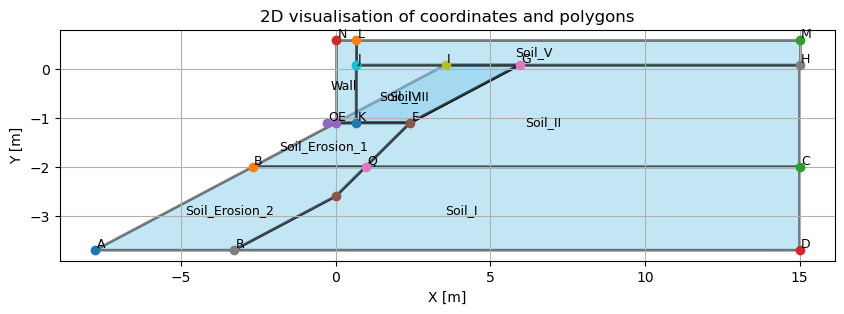

In [65]:
plot_geometry(points, polygons)

## Create soil in PLAXIS

In [66]:
g_i.polygon(Point_R, Point_P, Point_Q, Point_C, Point_D)
g_i.Polygon_1.Name = 'Soil_I'
g_i.Soil_8.Material = [m for m in g_i.Materials if m.Name == 'Hollandveen'][0]

In [67]:
g_i.polygon(Point_Q, Point_F, Point_G, Point_H, Point_C)
g_i.Polygon_1.Name = 'Soil_II'
g_i.Soil_9.Material = [m for m in g_i.Materials if m.Name == 'GeulopvullingKlei'][0]

In [68]:
g_i.polygon(Point_E, Point_I, Point_G, Point_F)
g_i.Polygon_1.Name = 'Soil_III'
g_i.Soil_10.Material = [m for m in g_i.Materials if m.Name == 'GeulopvullingKlei'][0]

In [69]:
g_i.polygon(Point_K, Point_J, Point_G, Point_F)
g_i.Polygon_1.Name = 'Soil_IV'
g_i.Soil_11.Material = [m for m in g_i.Materials if m.Name == 'GeulopvullingKlei'][0]

In [70]:
g_i.polygon(Point_J, Point_L, Point_M, Point_H)
g_i.Polygon_1.Name = 'Soil_V'
g_i.Soil_12.Material = [m for m in g_i.Materials if m.Name == 'Verharding'][0]

In [71]:
g_i.polygon(Point_B, Point_E, Point_F, Point_Q)
g_i.Polygon_1.Name = 'Soil_Erosion_1'
g_i.Soil_13.Material = [m for m in g_i.Materials if m.Name == 'GeulopvullingKlei'][0]

In [72]:
g_i.polygon(Point_A, Point_B, Point_Q, Point_P, Point_R)
g_i.Polygon_1.Name = 'Soil_Erosion_2'
g_i.Soil_14.Material = [m for m in g_i.Materials if m.Name == 'Hollandveen'][0]

## Structures

### Kesp

In [73]:
g_i.gotostructures()

# Create a plate material
EA = 1.21e9 # [kN/m] = [N/mm]
EI = 6.88e9*1e-6 # [kN/m^2/m] = 10^6 [N/mm^2/mm]
nu = 0.35

g_i.platemat("Identification", "Timber_Kesp",
             "MaterialType", "Elastic",
             "EA1", EA,
             "EI", EI,
             "StructNu", nu)

# Create plate
Kesp_Line = g_i.line(Point_O, Point_F)
g_i.Line_1.Name = 'Kesp_Line'

Kesp = g_i.plate(g_i.Kesp_Line)
g_i.Plate_1.Name = 'Kesp'

# Assign material to plate
g_i.Kesp.Material = [m for m in g_i.Materials if m.Name == 'Timber_Kesp'][0]

# Add positive interface
g_i.posinterface(g_i.Kesp_Line)
g_i.PositiveInterface_1.Name = 'Positive_IF_Kesp'

# Add negative interface
g_i.neginterface(g_i.Kesp_Line)
g_i.NegativeInterface_1.Name = 'Negative_IF_Kesp'

### Wall

In [74]:
# Create geometry wall
g_i.polygon(Point_E, Point_N, Point_L, Point_K)
g_i.Polygon_1.Name = 'Wall'

# Create wall material
E_masonry = 8e6 # [kN/m^2]
nu_masonry = 0.2 # [-]
gammaunsat_masonry = 19.5 # [kN/m^3]

g_i.soilmat("Identification", "Masonry",
            "SoilModel", "Linear Elastic",
            "DrainageType", "Non-porous",
            "gammaunsat", gammaunsat_masonry,
            "Eref", E_masonry,
            "nu", nu_masonry)

# Assign wall material
g_i.Soil_15.Material = [m for m in g_i.Materials if m.Name == 'Masonry'][0]

### Piles

In [75]:
# Create geometry piles
n_piles = 3
pile_spacing = 1.1 #[m]

# geometry pile 1
pile_1_x_bot = 0.1375 
pile_1_y_bot = -13.29
pile_1_x_top = pile_1_x_bot
pile_1_y_top = -1.104

Point_1_Pile_1 = [pile_1_x_bot, pile_1_y_bot]
Point_2_Pile_1 = [pile_1_x_top, pile_1_y_top]

# geometry pile 2
pile_2_x_bot = 0.1375 + pile_spacing
pile_2_y_bot = -13.29
pile_2_x_top = pile_2_x_bot
pile_2_y_top = -1.104

Point_1_Pile_2 = [pile_2_x_bot, pile_2_y_bot]
Point_2_Pile_2 = [pile_2_x_top, pile_2_y_top]

# geometry pile 3
pile_3_x_bot = 0.1375 + 2*pile_spacing
pile_3_y_bot = -13.29
pile_3_x_top = pile_3_x_bot
pile_3_y_top = -1.104

Point_1_Pile_3 = [pile_3_x_bot, pile_3_y_bot]
Point_2_Pile_3 = [pile_3_x_top, pile_3_y_top]

# Create timber material
E_timber = 11e6 # [kN/m^2]
nu_timber = 0.35 # [-]

# Create piles
Pile_1 = g_i.embeddedbeam(Point_1_Pile_1, Point_2_Pile_1)
Pile_2 = g_i.embeddedbeam(Point_1_Pile_2, Point_2_Pile_2)
Pile_3 = g_i.embeddedbeam(Point_1_Pile_3, Point_2_Pile_3)

# Rename embedded beams
g_i.EmbeddedBeam_1.Name = "Pile_1"
g_i.EmbeddedBeam_2.Name = "Pile_2"
g_i.EmbeddedBeam_3.Name = "Pile_3"

# Rename lines piles
g_i.Line_1.Name = 'Pile_1_Line'
g_i.Line_2.Name = 'Pile_2_Line'
g_i.Line_3.Name = 'Pile_3_Line'

In [76]:
E_timber = 11e6 # [kN/m^2] Stiffness
D = 0.2 # [m] Diameter
L_spacing = 1 # [m]
Gamma_Timber = 4.2 # [kN/m^3] Density
F_max = 100 # [kN] Base resistance

# Create Timber_Pile material
g_i.embeddedbeammat(("Identification", "Timber_Pile"),
                    ("MaterialType", "Elastic"),
                    ("Gamma", Gamma_Timber),
                    ("Lspacing", L_spacing),
                    ("Diameter", D),
                    ("E", E_timber),
                    ("Fmax",100))

# Assign Timber_Pile material to Embedded beams
g_i.Pile_1.Material = [m for m in g_i.Materials if m.Name == 'Timber_Pile'][0]
g_i.Pile_2.Material = [m for m in g_i.Materials if m.Name == 'Timber_Pile'][0]
g_i.Pile_3.Material = [m for m in g_i.Materials if m.Name == 'Timber_Pile'][0]

In [94]:
Gamma_Timber*D**2*np.pi/4 # kN/m/m]

0.13194689145077135

In [77]:
soft_shell = 21 # [mm]
D_degraded = D - soft_shell/1000 # [m] Diameter
E_timber_degraded = 11e6 # [kN/m^2] Stiffness

# Create Timber_Pile_degraded material
g_i.embeddedbeammat(("Identification", "Timber_Pile_degraded"),
                    ("MaterialType", "Elastic"),
                    ("Gamma", Gamma_Timber),
                    ("Lspacing", L_spacing),
                    ("Diameter", D_degraded),
                    ("E", E_timber_degraded),
                    ("Fmax",100))

<EmbeddedBeamMat {2B806893-6AD5-4DAC-955D-DC40B69DB37B}>

## Flow conditions

In [79]:
g_i.gotoflow()

WL_normal = g_i.waterlevel((xmin, -0.4), (xmax, -0.4)) # [m]
g_i.UserWaterLevel_1.Name = "WL_normal"

WL_excavation = g_i.waterlevel((xmin, y_kesp-0.5), (xmax, y_kesp-0.5)) # [m]
g_i.UserWaterLevel_1.Name = "WL_excavation"

### Creating load

In [80]:
# Create the top TAK load of 10 kN/m
g_i.gotostructures()
line_TAK = g_i.line((x_L, y_L), (xmax, y_L))[-1]
TAK_load = g_i.lineload(line_TAK)
g_i.LineLoad_1.Name = "TAK_load"
g_i.TAK_load.qy_start = -10 # [kN/m/m]

## Staged construction

### Create Phases

In [81]:
# Go to Staged Construction
g_i.gotostages()

# Set initial phase idenitification
Phase_0 = g_i.Phases[0]
n_phases = 10
phases = [Phase_0]

# Create other phases in a loop
for i in range(1, n_phases + 1):
    new_phase = g_i.phase(phases[i - 1])
    phases.append(new_phase)

# Display all phases
phases_id = g_i.Phases.Identification.value
print(f'Phases Identification property: {phases_id}')

Phases Identification property: ['Initial phase', 'Phase_1', 'Phase_2', 'Phase_3', 'Phase_4', 'Phase_5', 'Phase_6', 'Phase_7', 'Phase_8', 'Phase_9', 'Phase_10']


### Phase 0: Initial phase

In [82]:
soils_phase0 = [g_i.Soil_I, g_i.Soil_II, g_i.Soil_III, g_i.Soil_Erosion_1, g_i.Soil_Erosion_2]

for soil in soils_phase0:
    soil.activate(phases[0])

### Phase 1: Plastic-0 step

In [83]:
phase = phases[1]
phase.Deform.ResetDisplacements = True
phase.Deform.CalculationType = "Drained"

### Phase 2: Lower waterlevel

In [84]:
phase = phases[2]
phase.Deform.ResetDisplacements = True
phase.Deform.CalculationType = "Drained"

g_i.setglobalwaterlevel(g_i.WL_excavation, g_i.Phase_2)

'OK'

### Phase 3: Excavate

In [85]:
phase = phases[3]
phase.Deform.ResetDisplacements = True
phase.Deform.CalculationType = "Drained"

for phase in phases[3:]:
    g_i.Soil_III.deactivate(phase)

### Phase 4: Add piles

In [86]:
phase = phases[4]
phase.Deform.ResetDisplacements = True
phase.Deform.CalculationType = "Drained"

piles = [g_i.Pile_1, g_i.Pile_2, g_i.Pile_3]

for pile in piles:
    for phase in phases[4:]:
        pile.activate(phase)


### Phase 5: Add wall, kesp, interfaces

In [87]:
phase = phases[5]
phase.Deform.ResetDisplacements = False
phase.Deform.CalculationType = "Drained"

elements = [g_i.Wall, g_i.Kesp, g_i.Negative_IF_Kesp, g_i.Positive_IF_Kesp]

for element in elements:
    for phase in phases[5:]:
        element.activate(phase)

### Phase 6: Backfill soil

In [88]:
phase = phases[6]
phase.Deform.ResetDisplacements = False
phase.Deform.CalculationType = "Drained"

for phase in phases[6:]:
    g_i.Soil_IV.activate(phase)
    g_i.Soil_V.activate(phase)

### Phase 7: Heighten waterlevel

In [89]:
phase = phases[7]
phase.Deform.ResetDisplacements = False
phase.Deform.CalculationType = "Drained"
g_i.setglobalwaterlevel(g_i.WL_normal, g_i.Phase_7)

'OK'

### Phase 8: Apply current soil bedding

In [90]:
phase = phases[8]
phase.Deform.ResetDisplacements = False
phase.Deform.CalculationType = "Drained"

for phase in phases[8:]:
    g_i.Soil_Erosion_1.deactivate(phase)
    g_i.Soil_Erosion_2.deactivate(phase)

### Phase 9: Degradation timber piles

In [92]:
phase = phases[9]
phase.Deform.ResetDisplacements = False
phase.Deform.CalculationType = "Drained"

# Assign Timber_Pile material to Embedded beams

for phase in phases[9:]:
    g_i.Pile_1_1.Material[phase] = [m for m in g_i.Materials if m.Name == 'Timber_Pile_degraded'][0]
    g_i.Pile_2_1.Material[phase] = [m for m in g_i.Materials if m.Name == 'Timber_Pile_degraded'][0]
    g_i.Pile_3_1.Material[phase] = [m for m in g_i.Materials if m.Name == 'Timber_Pile_degraded'][0]

### Phase 10: Apply loads

In [93]:
phase = phases[10]
phase.Deform.ResetDisplacements = False
phase.Deform.CalculationType = "Drained"

g_i.TAK_load.activate(phase)

'OK'

# Mesh

In [37]:
g_i.gotomesh()
g_i.mesh()

'Generated 1515 elements, 12711 nodes'

## Calculate

In [38]:
g_i.gotostages()

for i in range(len(phases)):
    g_i.calculate(phases[i])

## View results

In [39]:
phase = phases[-1]
g_i.view(phase)

10001

## Total displacement

In [40]:
# Get the result data
x = g_o.getresults(phase, g_o.ResultTypes.Soil.X, "node")
y = g_o.getresults(phase, g_o.ResultTypes.Soil.Y, "node")
u_tot = g_o.getresults(phase, g_o.ResultTypes.Soil.Utot, "node")  # total displacement

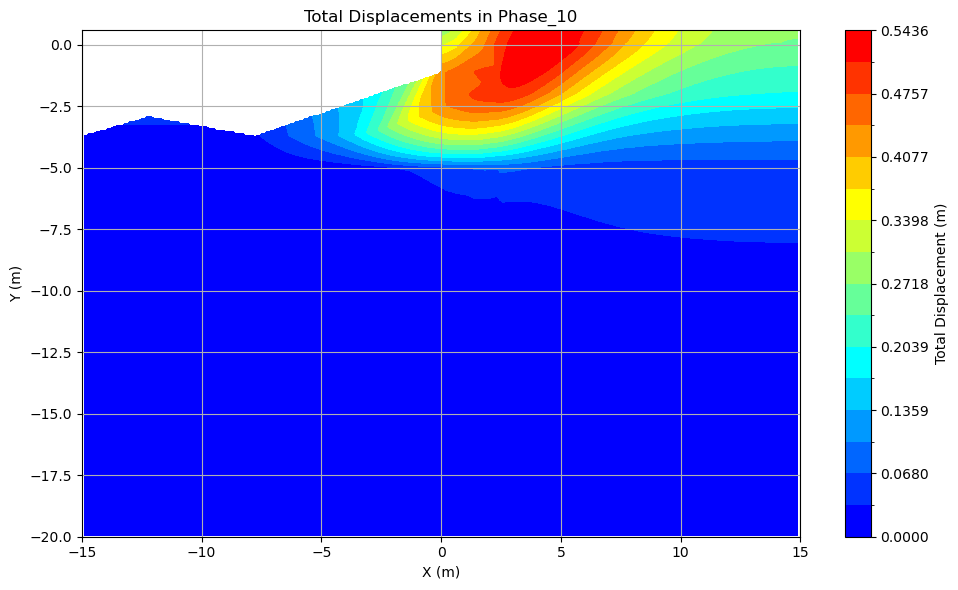

In [41]:
# Step 1: Create grid
xi = np.linspace(min(x), max(x), 300)
yi = np.linspace(min(y), max(y), 300)
xi, yi = np.meshgrid(xi, yi)

# Step 2: Interpolate displacement onto grid
zi = griddata((x, y), u_tot, (xi, yi), method='linear')

# OPTIONAL Step 3: Mask out areas outside convex hull (or use alpha shape for better boundaries)
boundary_points = np.array([    (xmin, ymin),
    (xmin, -2.4),
    Point_A,
    Point_E,
    Point_N,
    Point_M,
    (xmax, ymin)])
polygon_path = Path(boundary_points)

# Mask points outside the polygon
grid_points = np.vstack((xi.flatten(), yi.flatten())).T
mask = ~polygon_path.contains_points(grid_points)
zi_flat = zi.flatten()
zi_flat[mask] = np.nan
zi_masked = zi_flat.reshape(xi.shape)

# Step 4: Create PLAXIS-style colormap
boundaries = np.linspace(np.nanmin(u_tot), np.nanmax(u_tot), len(colors) + 1)
norm = BoundaryNorm(boundaries, cmap_PLAXIS.N)

# Step 5: Plot
plt.figure(figsize=(10, 6))
cf = plt.contourf(xi, yi, zi_masked, levels=boundaries, cmap=cmap_PLAXIS, norm=norm)
cb = plt.colorbar(cf)
cb.set_label('Total Displacement (m)')

plt.xlabel('X (m)')
plt.ylabel('Y (m)')
# plt.xlim(-5, 10)
# plt.ylim(-6, y_GL)
plt.title(f'Total Displacements in {phase.Name}')
plt.grid(True)
plt.tight_layout()
plt.show()

## Create phased displacements view

The initial phase is skipped, as no phase displacements are observed in the initial phase.

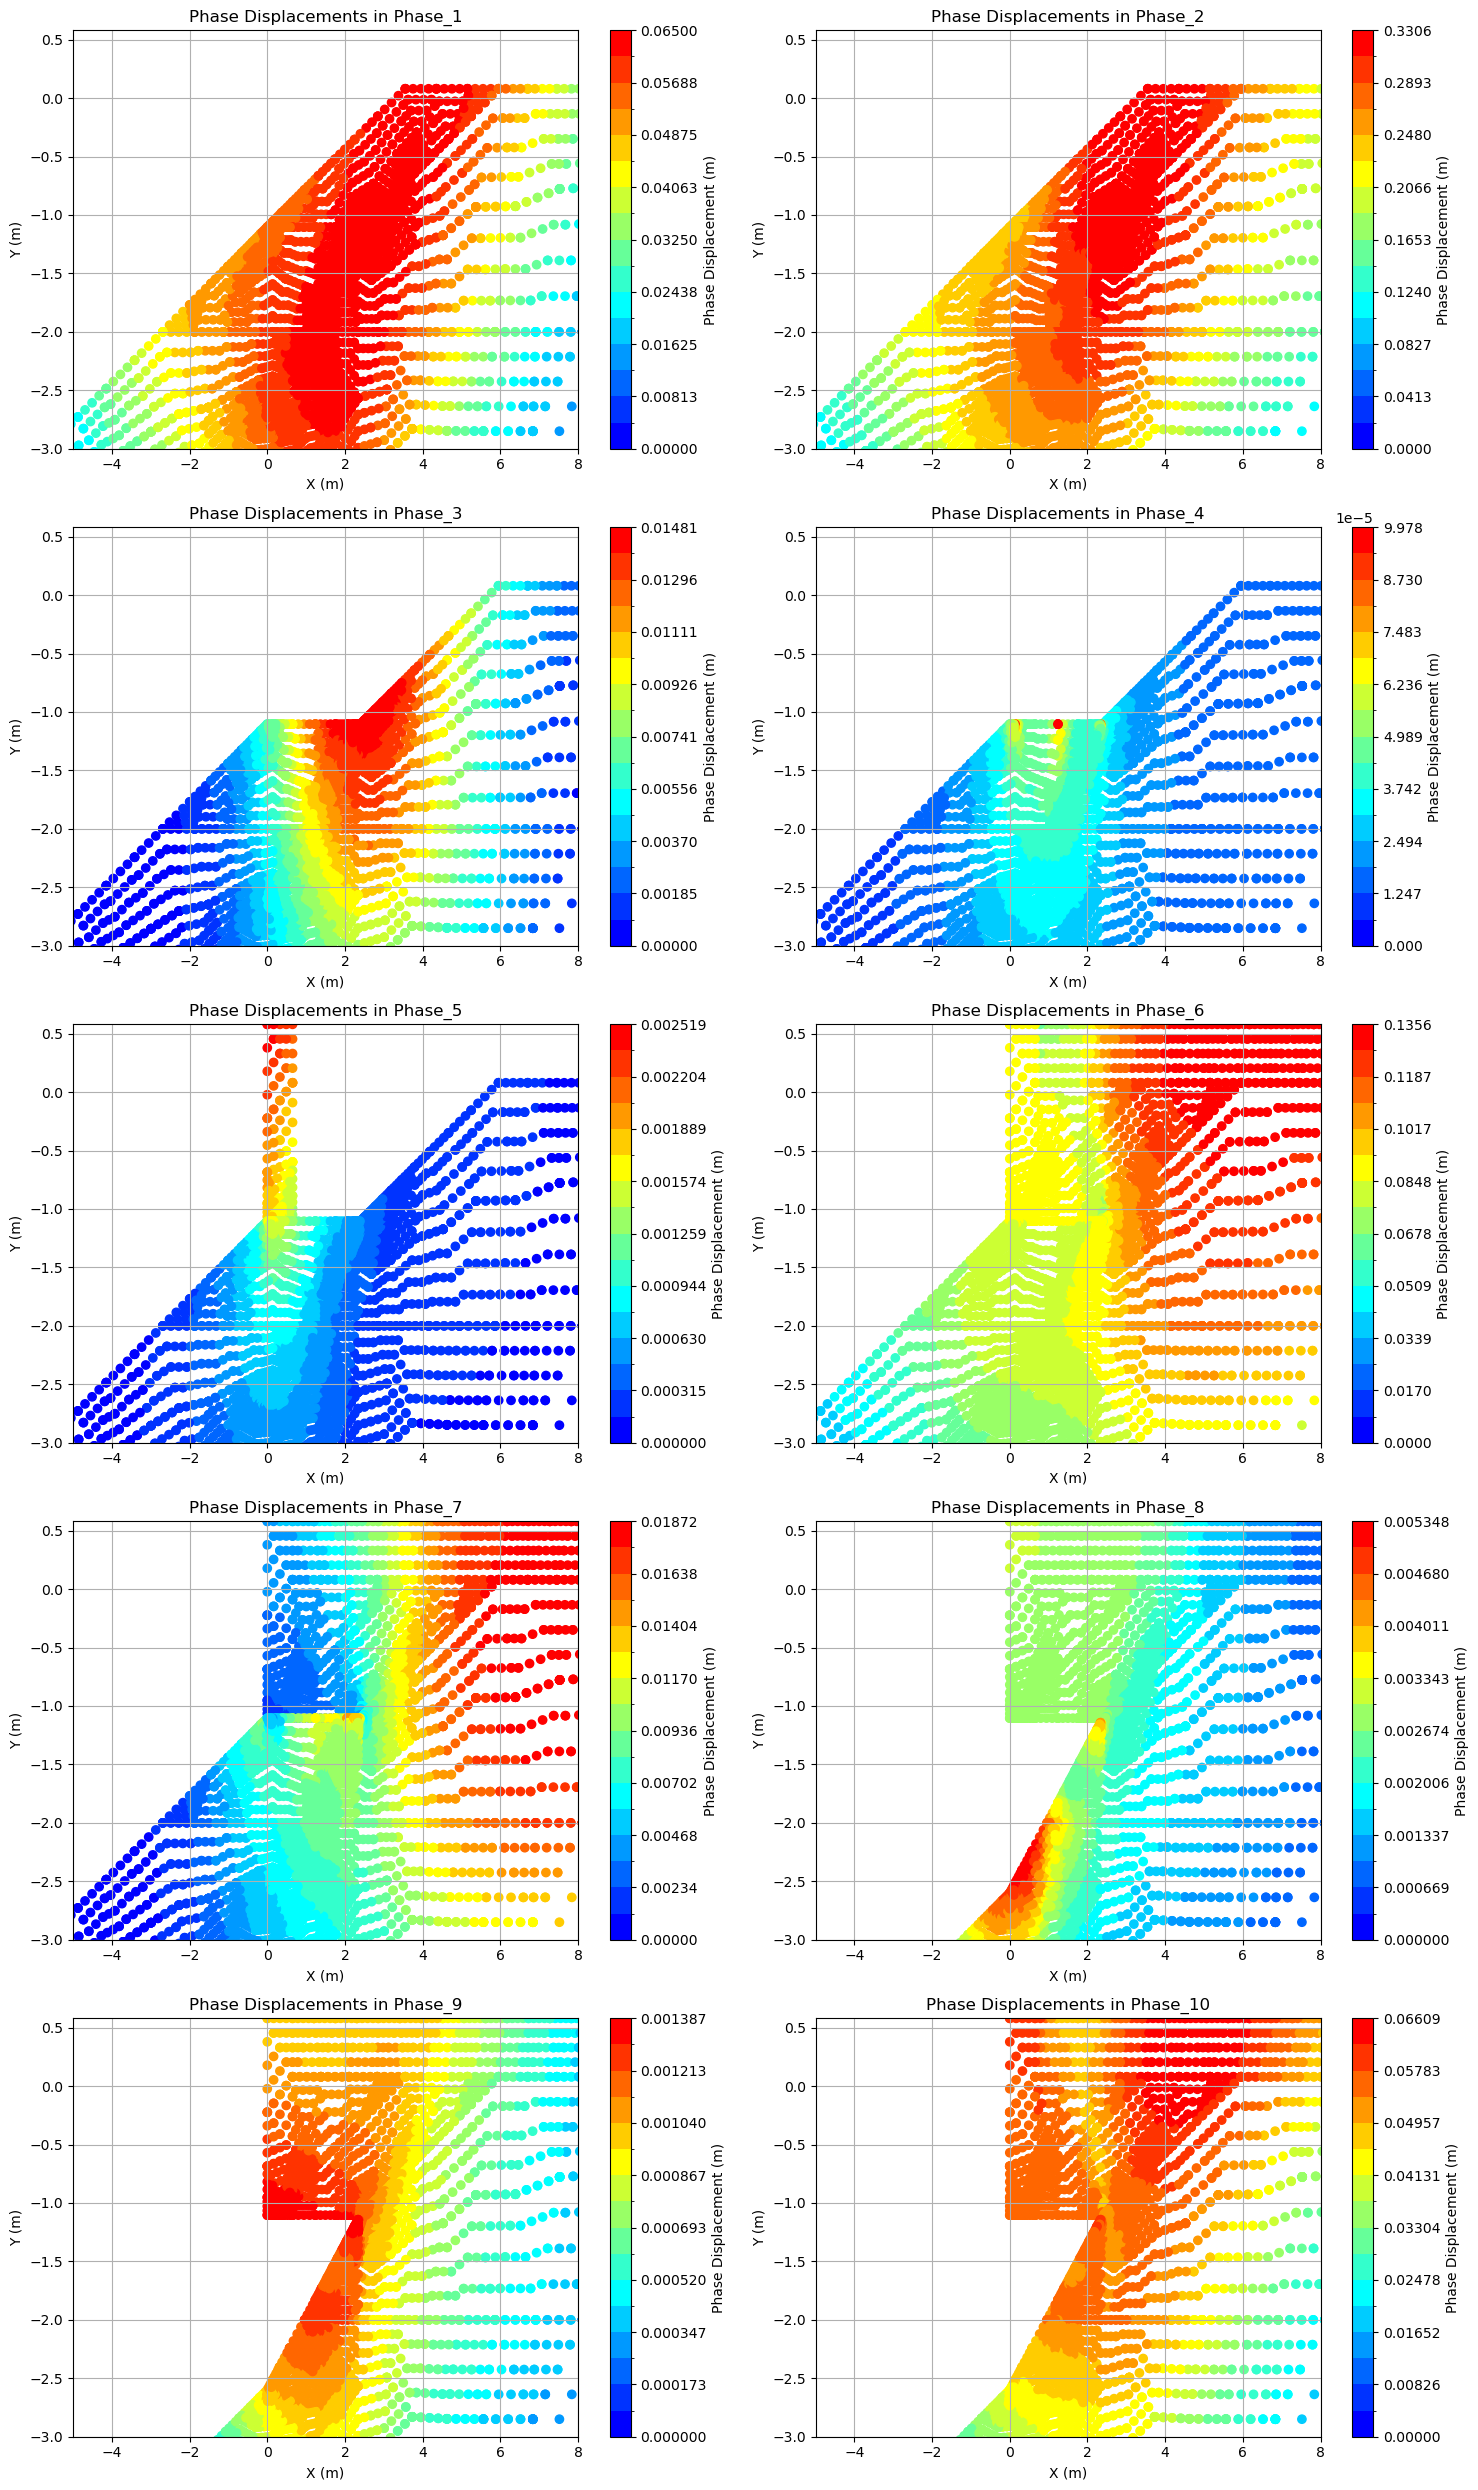

In [42]:
# Define the number of columns per row
max_columns = 2
num_phases = len(phases)-1
num_rows = (num_phases + max_columns - 1) // max_columns  # This calculates the number of rows needed

xmin_plot, xmax_plot = -5, 8
ymin_plot, ymax_plot = -3, y_GL

# Create the figure with subplots
fig, axes = plt.subplots(num_rows, max_columns, figsize=(15, 5 * num_rows))

# Flatten axes array for easier iteration if there are more than one row
axes = axes.flatten()

# Iterate through each phase and plot its data
for i in range(num_phases):
    phase = phases[i+1]
    g_i.view(phase)

    # Get the result data
    x = g_o.getresults(phase, g_o.ResultTypes.Soil.X, "node")
    y = g_o.getresults(phase, g_o.ResultTypes.Soil.Y, "node")
    PUtot = g_o.getresults(phase, g_o.ResultTypes.Soil.PUtot, "node")  # total displacement

    # Step 4: Create PLAXIS-style colormap
    boundaries = np.linspace(np.min(PUtot), np.max(PUtot), len(colors) + 1)
    norm = BoundaryNorm(boundaries, cmap_PLAXIS.N)

    # Plot on the corresponding subplot
    ax = axes[i]
    cf = ax.scatter(x, y, c=PUtot, cmap=cmap_PLAXIS, norm=norm)
    cb = plt.colorbar(cf, ax=ax)
    cb.set_label('Phase Displacement (m)')
    
    ax.set_xlabel('X (m)')
    ax.set_ylabel('Y (m)')
    ax.set_xlim(xmin_plot, xmax_plot)
    ax.set_ylim(ymin_plot, ymax_plot)
    ax.set_title(f'Phase Displacements in {phase.Name}')
    ax.grid(True)

# Turn off any unused subplots
for j in range(num_phases, len(axes)):
    axes[j].axis('off')

# Adjust layout for a better fit
plt.tight_layout()
plt.show()

## Structural forces in Piles

In [43]:
# Select the final phase for the forces
phase = phases[-1]
g_i.view(phase)

# print(dir(g_o.ResultTypes.EmbeddedBeam)) # This helps to find the right output
# To create an np.array for each of these results and store them in a CSV file with the respective variable names (x, y, Ux, Uy, N, Q, M) as column headers, here's the script:
# Assuming the values are obtained from getresults and are lists or arrays
x = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.X, "node"))
y = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.Y, "node"))
Ux = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.Ux, "node"))
Uy = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.Uy, "node"))
N = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.Nx2D, "node"))
Q = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.Q2D, "node"))
M = np.array(g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.M2D, "node"))

In [44]:
# Use the geometry of the piles to split the results for the different piles by creating an index array
def split_pile_results(n_piles=n_piles, pile_spacing=pile_spacing, pile_1_x_top=pile_1_x_top):
    x = g_o.getresults(phase, g_o.ResultTypes.EmbeddedBeam.X, "node")
    pile_number = np.zeros(len(x))

    x_pile = np.zeros(n_piles)
    for i in range(len(x_pile)):
        x_pile[i] = pile_1_x_top + pile_spacing * i

    for i in range(len(x)):
        for j in range(n_piles):
            if np.isclose(x[i], x_pile[j], rtol=1e-05, atol=1e-08):
                pile_number[i] = int(j+1)

    return pile_number

pile_number = split_pile_results()

In [45]:
# Create function that can return a specific property of a certain pile
def xy_pile(quantity_x, quantity_y, pile, pile_number=pile_number):
    quantity_x_np = np.array(quantity_x)
    quantity_y_np = np.array(quantity_y)
    index = int(pile)
    
    return quantity_x_np[pile_number==index], quantity_y_np[pile_number==index]

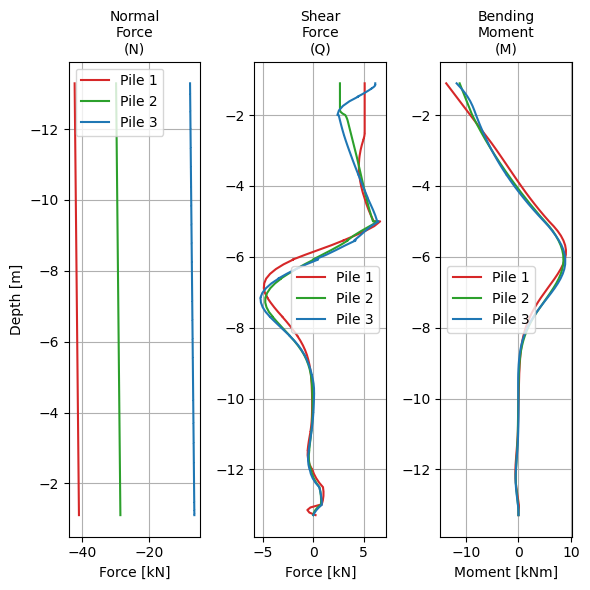

In [46]:
# Set up figure with 3 subplots
width = 6
height = width
fig, axs = plt.subplots(1, 3, figsize=(width, height))

# Define colors for piles
colors = ['tab:red', 'tab:green', 'tab:blue']
pile_labels = ['Pile 1', 'Pile 2', 'Pile 3']

# Loop over each pile
for i in range(1, 4):
    N_i, y_i = xy_pile(N, y, i)
    Q_i, _   = xy_pile(Q, y, i)
    M_i, _   = xy_pile(M, y, i)
    
    axs[0].plot(N_i, y_i, label=pile_labels[i-1], color=colors[i-1])
    axs[1].plot(Q_i, y_i, label=pile_labels[i-1], color=colors[i-1])
    axs[2].plot(M_i, y_i, label=pile_labels[i-1], color=colors[i-1])

# Customize each subplot
for ax in axs:
    ax.grid(True)  # Add gridlines to each subplot

# Adjust titles with a smaller font size
axs[0].set_title("Normal\nForce\n(N)", fontsize=10)
axs[0].set_xlabel("Force [kN]")
axs[0].set_ylabel("Depth [m]")
axs[0].invert_yaxis()
axs[0].legend()

axs[1].set_title("Shear\nForce\n(Q)", fontsize=10)
axs[1].set_xlabel("Force [kN]")
axs[1].legend()

axs[2].set_title("Bending\nMoment\n(M)", fontsize=10)
axs[2].set_xlabel("Moment [kNm]")
axs[2].legend()

plt.tight_layout()
plt.show()

In [47]:
# s_i.close()